In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
sys.path.insert(0, '../../esinet')

from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.util import find_corner
pp = dict(surface='white', hemi='both', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

Simulating data based on sparse patches.


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


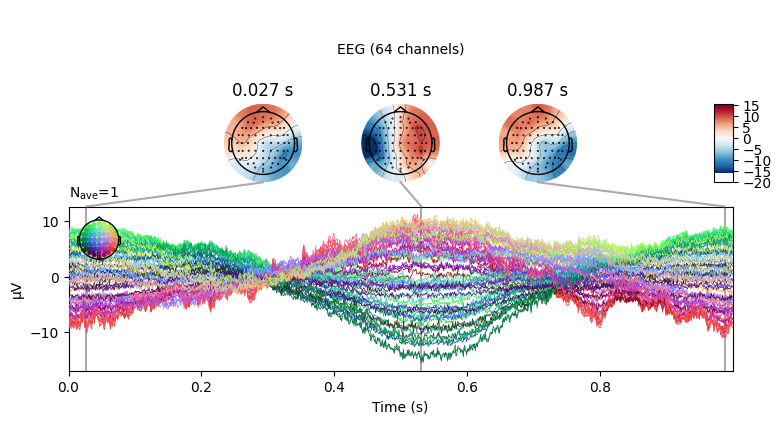

In [50]:
settings = dict(
    number_of_sources=(1, 32),
    extents=(1, 25),
    duration_of_trial=1,
    amplitudes=(1, 100),
    target_snr=(0.5, 20),
    # beta_noise=0,
    method="standard")

sim = Simulation(fwd, info, settings).simulate(200)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

evoked.plot_joint()

In [51]:
# Extract Data
Y = np.stack([epochs.average().data for epochs in sim.eeg_data], axis=0)
Y = np.stack([y - y.mean(axis=0) for y in Y], axis=0)

covs = np.stack([y@y.T for y in Y], axis=0)
eigs = np.stack([np.linalg.svd(C, full_matrices=False)[1] for C in covs], axis=0)
eigs_normed =  (eigs.T/eigs.max(axis=1)).T

# Get Targets
targets = sim.simulation_info.number_of_sources.values.astype(int)

# Absolute Thresholding

## Simple

In [180]:
thr = 0.009
model = lambda x: np.array([np.where(xx < thr)[0][0]+1 for xx in x])
estimates = model(eigs_normed)

plt.figure()
plt.scatter(targets, estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')

median_dev = np.median(abs(targets - estimates))
mean_dev = np.mean(abs(targets - estimates))
print("Median Deviation: ", median_dev)
print("Mean Deviation: ", mean_dev)

Median Deviation:  1.0
Mean Deviation:  4.115


## L Curve

In [143]:
model = lambda x: np.array([find_corner(np.arange(len(xx)), xx) for xx in x])

estimates = model(eigs_normed)
plt.figure()
plt.scatter(targets, estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("L Curve")

median_dev = np.median(abs(targets - estimates))
mean_dev = np.mean(abs(targets - estimates))
print("Median Deviation: ", median_dev)
print("Mean Deviation: ", mean_dev)

Median Deviation:  1.0
Mean Deviation:  4.73


# Relative Thresholding

## Simple

In [182]:
thr = 0.001
model = lambda x: np.array([np.where(abs(np.diff(xx)) < thr)[0][0]+1 for xx in x])
estimates = model(eigs_normed)

plt.figure()
plt.scatter(targets, estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')

median_dev = np.median(abs(targets - estimates))
mean_dev = np.mean(abs(targets - estimates))
print("Median Deviation: ", median_dev)
print("Mean Deviation: ", mean_dev)

Median Deviation:  1.0
Mean Deviation:  3.76


## L Curve

In [178]:
model = lambda x: np.array([find_corner(np.arange(len(xx)), abs(np.diff(xx)))+1 for xx in x])

estimates = model(eigs_normed)
plt.figure()
plt.scatter(targets, estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("L Curve")

median_dev = np.median(abs(targets - estimates))
mean_dev = np.mean(abs(targets - estimates))
print("Median Deviation: ", median_dev)
print("Mean Deviation: ", mean_dev)

Median Deviation:  1.0
Mean Deviation:  4.795


# Regression

In [53]:
n_train = 150

## Linreg

In [54]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(eigs_normed[:n_train], targets[:n_train])

estimates = model.predict(eigs_normed[n_train:])

plt.figure()
plt.scatter(targets[n_train:], estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("Lin Reg")

Text(0.5, 1.0, 'Lin Reg')

## Lasso

In [56]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(eigs_normed[:n_train], targets[:n_train])

estimates = model.predict(eigs_normed[n_train:])

plt.figure()
plt.scatter(targets[n_train:], estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("Lasso Reg")

Text(0.5, 1.0, 'Lasso Reg')

## Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(eigs_normed[:n_train], targets[:n_train])

estimates = model.predict(eigs_normed[n_train:])

plt.figure()
plt.scatter(targets[n_train:], estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("Log Reg")

Text(0.5, 1.0, 'Log Reg')

## Testing stuff

In [62]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(eigs_normed[:n_train], targets[:n_train])

estimates = model.predict(eigs_normed[n_train:])

plt.figure()
plt.scatter(targets[n_train:], estimates)
plt.xlabel("Targets")
plt.ylabel("Estimates")
plt.plot([0,32], [0, 32], '--k')
plt.title("Perceptron Reg")

Text(0.5, 1.0, 'Perceptron Reg')